# ARIMA

## Importing the libraries

In [280]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import tensorflow as tf

### Set seed

In [281]:
np.random.seed(123)
tf.random.set_seed(123)

## Importing the dataset

In [282]:
#Because time series are ordered sequences we need to indicate the column according to wich the rows will be indexed
#parse_date will put the column with dates in the year/month/day format
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

Check how the dataset looks

In [283]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


**The first step when working with time series is to plot and inspect the progression of the series in time.**

Observe that the time series is not stationary: it has a positive trend, some seasonality and a variance that increases with time (heteroskedasticity)

<AxesSubplot:xlabel='Month'>

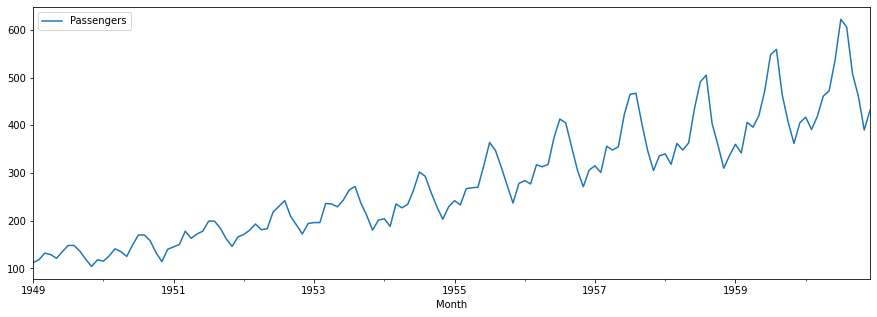

In [284]:
df.plot(figsize=(15, 5))

## Data Transformations

**Let us take the first difference to try and make the time series stationary:**

In [285]:
df['1stdiff'] = df['Passengers'].diff()

Plot the first difference to see if it helped with non-stationarity

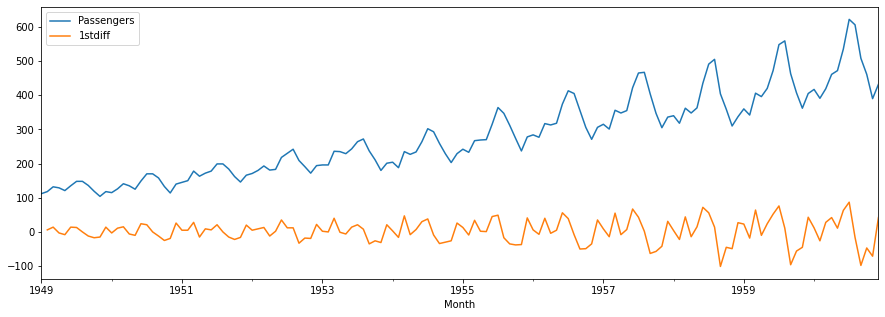

In [286]:
df.plot(figsize=(15, 5));

The first difference helped with the trend, but we can stil see some seasonality and a variance that increases with time.

**A very common transformation with time series data is the log transformation, it helps with non-stationarity issues as well.**

Let's take the log and then plot the data to see if they look more stationary.

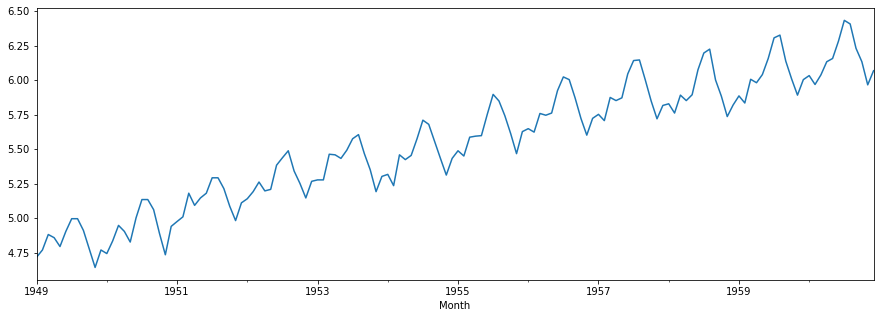

In [287]:
df['LogPassengers'] = np.log(df['Passengers'])
df['LogPassengers'].plot(figsize=(15, 5));

It appears that the log transformation helped a bit since the variance looks a bit more stable over time, nevetheless there is is still a trend, seasonality and some heteroskedasticity left.

**Let us take the first difference of our logged variable to see if that will help with making the time series stationary.** 

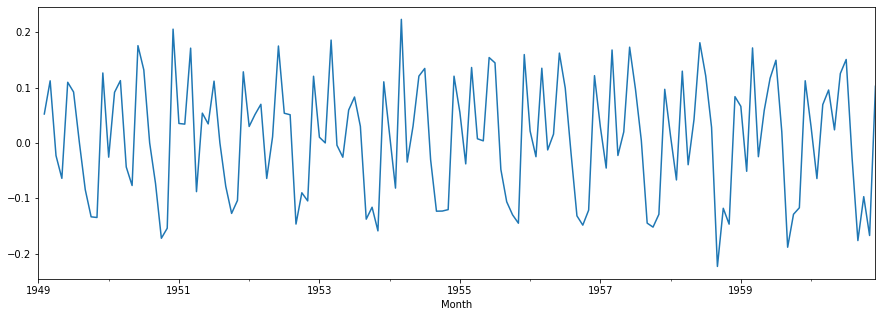

In [288]:
df['Log1stDiff'] = df['LogPassengers'].diff()
df['Log1stDiff'].plot(figsize=(15, 5));

This looks much closer to a stationary time series. There is still some cyclicality that should be taken care of, but my guess is that when we will fit the ARIMA model using the first difference of the log transformed Passengers, we'll get the best forecasts.  

## Splitting the dataset into the Training set and Test set

Because time series are sequences, we'll take the *y* values for the last 12 months and assign them to the test set, and the rest will go into the training set.

In [289]:
df.index.freq = 'MS'

Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

We'll also index the rows in the training and testing set

In [290]:
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

## Training the ARIMA model on the Training set

First train the naive version of the model where predictions will be made by accounting for *y(t)* only one period in the past (i.e. *y(t-1)*)

In [291]:
arima = ARIMA(train['Passengers'], order=(1,0,0))
arima_result = arima.fit()

## Predicting results for the training set

To see first how well the model can fit the data in the training set, create predictions for the rows that went into the training set and save them in the AR(1) column. Later we'll see how well it can forecast into the future (that is how well it can forecast the values from the training set).

In [292]:
df.loc[train_idx, 'AR(1)'] = arima_result.predict(start=train.index[0], end=train.index[-1])

Plot the real data in the training set against the model's predictions stored in the AR(1) column

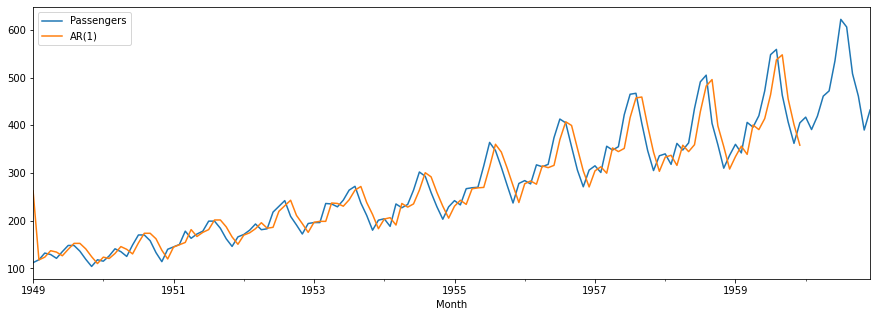

In [293]:
df[['Passengers', 'AR(1)']].plot(figsize=(15, 5));

As expected the model seems to simply mimic the time series by projecting the past values one period back into the future. 

#Predicting results for the test set

In [294]:
prediction_result = arima_result.get_forecast(Ntest)
forecast = prediction_result.predicted_mean
df.loc[test_idx, 'AR(1)'] = forecast

Plot the forecasts:

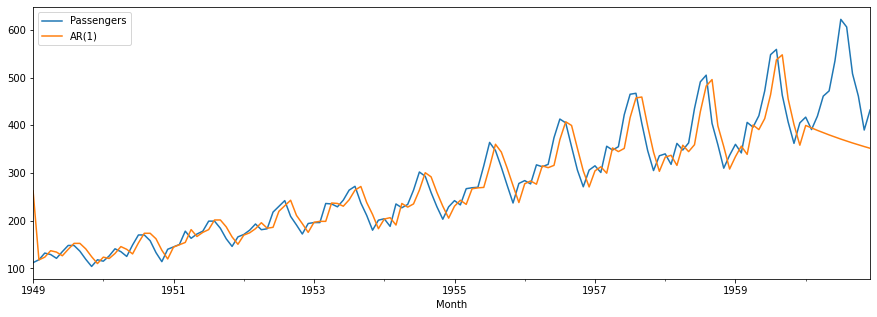

In [295]:
df[['Passengers', 'AR(1)']].plot(figsize=(15, 5));

The forecasts don't look very good even though the model predictions seemed to follow the true time series pretty close. This is what one would expect to see with a naive forecaster (it will mimic the data in the training set, but will not be able to make good forecasts). 


#Exploring the predictions further

Let us look at and plot the confidence intervals for our forecasts. This will give us an idea of how precise our forcasts are (narrower confidence intervals-> better forecasts). 

In [296]:

prediction_result.conf_int()

,lower Passengers,upper Passengers
1960-01-01,338.658210,460.451500
1960-02-01,309.826171,478.809354
1960-03-01,287.732168,490.829379
1960-04-01,269.338256,499.534230
1960-05-01,253.432284,506.121347
1960-06-01,239.373402,511.217437
1960-07-01,226.768868,515.201638
1960-08-01,215.354570,518.324977
1960-09-01,204.941150,520.764224
1960-10-01,195.386337,522.649550


In [297]:
def plot_fit_and_forecast(result):
  fig, ax = plt.subplots(figsize=(15, 5))
  ax.plot(df['Passengers'], label='data')

  # plot the curve fitted on train set
  train_pred = result.fittedvalues
  ax.plot(train.index, train_pred, color='green', label='fitted')

  # forecast the test set
  prediction_result = result.get_forecast(Ntest)
  conf_int = prediction_result.conf_int()
  lower, upper = conf_int['lower Passengers'], conf_int['upper Passengers']
  forecast = prediction_result.predicted_mean
  ax.plot(test.index, forecast, label='forecast')
  ax.fill_between(test.index, \
                  lower, upper, \
                  color='red', alpha=0.3)
  ax.legend()


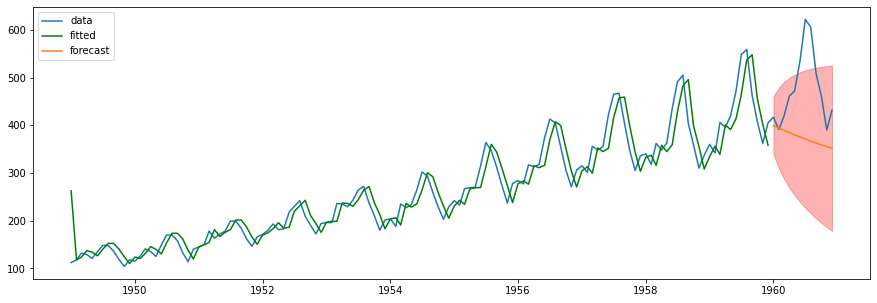

In [298]:
  plot_fit_and_forecast(arima_result)

The confidence intervals are large, as would be expected with such forecasts. 

#Let us explore other model configurations 

/home/ion/Desktop/UTM/Master/RNDL/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ion/Desktop/UTM/Master/RNDL/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


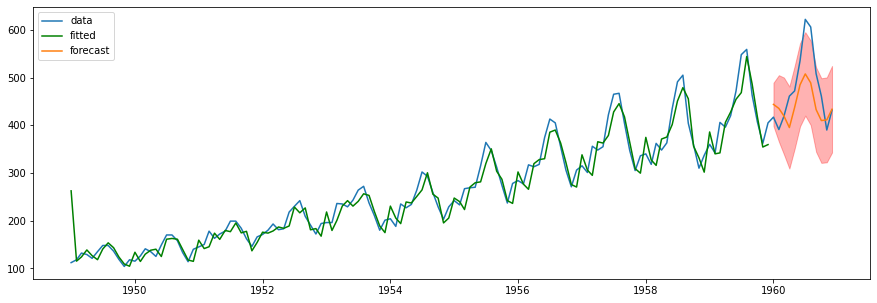

In [299]:
arima = ARIMA(train['Passengers'], order=(10,0,0)) # AR(10)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

Appears to make better forcasts, but let's see if we can get even better.

/home/ion/Desktop/UTM/Master/RNDL/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


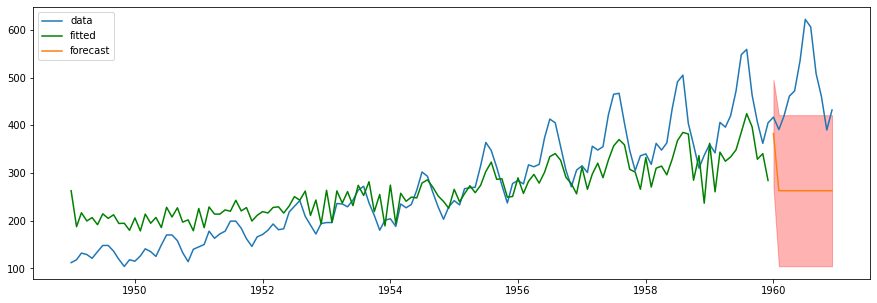

In [300]:
arima = ARIMA(train['Passengers'], order=(0,0,1)) # MA(1)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

The MA (1) doesn't seem to be making a good job. 

The model below ARIMA (8,1,1) - will take the first difference of y(t). 
The nice thing about using ARIMA models is that you don't have to 'undo' the differencing when making predictions (if you are using classical ML models, and your data is non-stationary and you use the differencing method, you will need to transform your data back when making predictions).

In [301]:
arima = ARIMA(train['Passengers'], order=(8,1,1)) #ARIMA (8,1,1) - will take the first difference of 
arima_result_811 = arima.fit()

We'll need to write out again the code for the plot because now after differencing we'll be missing the first row and will need to use the plot_fit_and_forecast_int function.

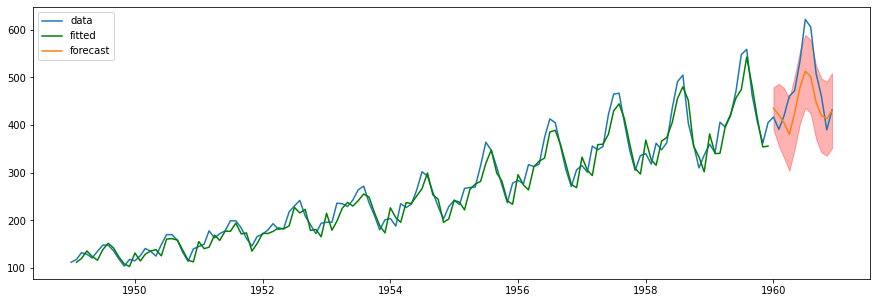

In [302]:
def plot_fit_and_forecast_int(result, d, col='Passengers'):
  fig, ax = plt.subplots(figsize=(15, 5))
  ax.plot(df[col], label='data')

  # plot the curve fitted on train set
  train_pred = result.predict(start=train.index[d], end=train.index[-1])
  ax.plot(train.index[d:], train_pred, color='green', label='fitted')

  # forecast the test set
  prediction_result = result.get_forecast(Ntest)
  conf_int = prediction_result.conf_int()
  lower, upper = conf_int[f'lower {col}'], conf_int[f'upper {col}']
  forecast = prediction_result.predicted_mean
  ax.plot(test.index, forecast, label='forecast')
  ax.fill_between(test.index, \
                  lower, upper, \
                  color='red', alpha=0.3)
  ax.legend()

plot_fit_and_forecast_int(arima_result_811, 1)

These predictions look best than anything we have seen before, and it makes sense since we saw that the first difference removes the trend.

**Let us try now the logged version and see if this will give us maybe even better results**

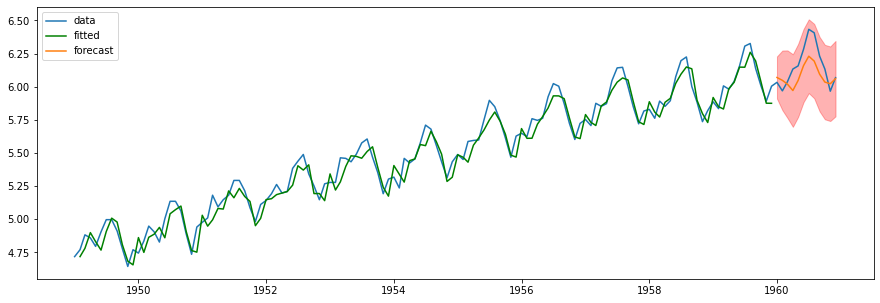

In [303]:
arima = ARIMA(train['LogPassengers'], order=(8,1,1)) #ARIMA(8,1,1)log
arima_result_log811 = arima.fit()
plot_fit_and_forecast_int(arima_result_log811, 1, col='LogPassengers')

ARIMA(8,1,1)log seems marginally better. The model seems to create forecasts that predict better the peaks. Also the confidence intervals now include the peak. 


**NOTE:** in this graph you see the logged versions of both the true y values and the predictions. If you are interested in the actual numerical predictions, you will have to undo the log transformation. 

/home/ion/Desktop/UTM/Master/RNDL/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ion/Desktop/UTM/Master/RNDL/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


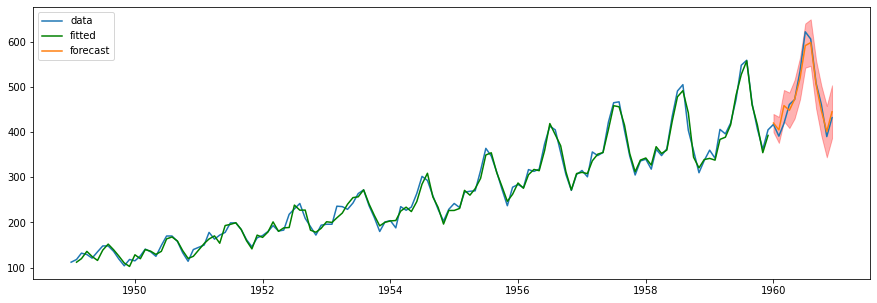

In [304]:
arima = ARIMA(train['Passengers'], order=(12,1,0)) #ARIMA(12,1,0)
arima_result_1210 = arima.fit()
plot_fit_and_forecast_int(arima_result_1210, 1, col='Passengers')

ARIMA(12,1,0) appears to give the best forcasts for now.

/home/ion/Desktop/UTM/Master/RNDL/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


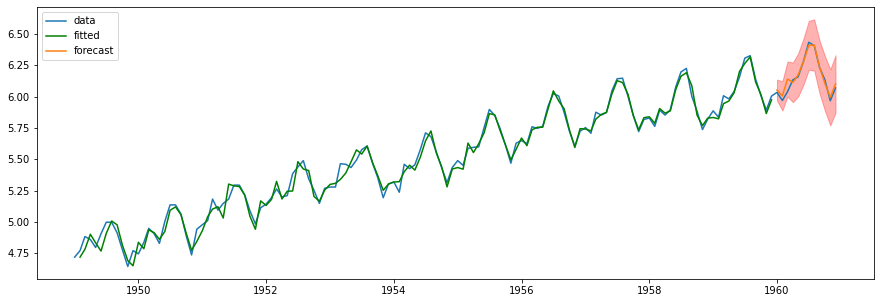

In [305]:
arima = ARIMA(train['LogPassengers'], order=(12,1,0))
arima_result_log1210 = arima.fit()
plot_fit_and_forecast_int(arima_result_log1210, 1, col='LogPassengers')

ARIMA(12,1,0)log seems to fit the data best.

#Computing the goodness of fit of the models

In [306]:
def rmse(result, is_logged):
  forecast = result.forecast(Ntest)
  if is_logged:
    forecast = np.exp(forecast)
  
  t = test['Passengers']
  y = forecast
  return np.sqrt(np.mean((t - y)**2))

In [307]:
print("ARIMA(8,1,1):", rmse(arima_result_811, False))
print("ARIMA(8,1,1) logged:", rmse(arima_result_log811, True))
print("ARIMA(12,1,0):", rmse(arima_result_1210, False))
print("ARIMA(12,1,0) logged:", rmse(arima_result_log1210, True))

ARIMA(8,1,1): 59.064589036931906
ARIMA(8,1,1) logged: 61.60257758050582
ARIMA(12,1,0): 17.49284028832071
ARIMA(12,1,0) logged: 16.12249766268653


As expected, the last model ARIMA(12,1,0)log seems to be offering the best forecasts and the lowests root mean squared errors. 

#Alternatives

1. One could use the ACF, PACF and the ADF test to find the hyper parameters for ARIMA(p,d,q)

2. One could use Auto-ARIMA for the parameters to be found through step iterations based on an information crterion like AIC or BIC.

In [308]:
print(df)

# get first value of Passengers
first_passengers_value = df.loc[train.index[0], 'Passengers']

            Passengers  1stdiff  LogPassengers  Log1stDiff       AR(1)
Month                                                                 
1949-01-01         112      NaN       4.718499         NaN  262.490027
1949-02-01         118      6.0       4.770685    0.052186  117.750054
1949-03-01         132     14.0       4.882802    0.112117  123.520801
1949-04-01         129     -3.0       4.859812   -0.022990  136.985877
1949-05-01         121     -8.0       4.795791   -0.064022  134.100503
...                ...      ...            ...         ...         ...
1960-08-01         606    -16.0       6.406880   -0.026060  366.839773
1960-09-01         508    -98.0       6.230481   -0.176399  362.852687
1960-10-01         461    -47.0       6.133398   -0.097083  359.017943
1960-11-01         390    -71.0       5.966147   -0.167251  355.329721
1960-12-01         432     42.0       6.068426    0.102279  351.782421

[144 rows x 5 columns]


In [312]:
# prepare dataset for RNN
def prepare_dataset(df, look_back=1):
    X, Y = [], []
    for i in range(len(df) - look_back):
        X.append(df[i:(i+look_back)])
        Y.append(df[i+look_back])
    return np.array(X), np.array(Y)


look_back = 1
# or maybe use Log1stDiff
df = df.fillna(0)
X, Y = prepare_dataset(df['Log1stDiff'], look_back)


# split into train and test sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
trainX, testX = X[0:train_size,:], X[train_size:len(X),:]
trainY, testY = Y[0:train_size], Y[train_size:len(Y)]

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))



Epoch 1/100
4/4 [==============================] - 1s 88ms/step - loss: 0.0108 - val_loss: 0.0133
Epoch 2/100
4/4 [==============================] - 0s 5ms/step - loss: 0.0108 - val_loss: 0.0133
Epoch 3/100
4/4 [==============================] - 0s 5ms/step - loss: 0.0107 - val_loss: 0.0133
Epoch 4/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0133
Epoch 5/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0133
Epoch 6/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0133
Epoch 7/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0133
Epoch 8/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0133
Epoch 9/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0134
Epoch 10/100
4/4 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0134
Epoch 11/100
4/4 [==========

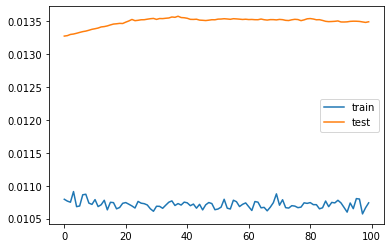

In [313]:
# Create a one-layer RNN with 25 units (neurons). Train it for 100 epochs with the default mini batch size of 32
# Compile and fit the model. When compiling, specify the ‘sgd’ optimizer, and choose the ‘accuracy’ metric to judge the goodness of your predictions.
# To compare further on the prediction results with the true values in the test set, specify inside the fit function your validation data: validation_data = (X_test, y_test). 
# Save the history of the loss and the accuracy results in each epoch as the model is being trained, so that you can later on plot them and compare.

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


model = Sequential()
model.add(LSTM(25, input_shape=(1, look_back)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='sgd')
history = model.fit(trainX, trainY, epochs=100, batch_size=32, validation_data=(testX, testY))

# Plot the loss and accuracy in each epoch for the training set as well as the validation set.
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()



Comment on your results. Do you see signs of overfitting? If yes, explain. If no, explain.

Do you see signs of vanishing or exploding gradient?

Explain how the two would manifest in your graph.

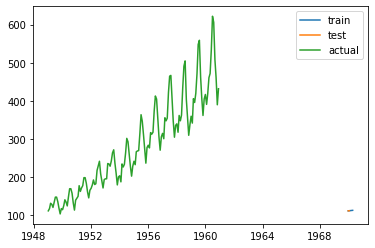

In [316]:
# Compute the model predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

def rebuild_diffed(series: pd.DataFrame, first_element_original):
    cumsum = series.cumsum()
    return cumsum.fillna(0) + first_element_original

# create dataframe from the predictions
trainPredict = pd.DataFrame(trainPredict)
trainPredict.columns = ['Prediction']


# create dataframe from the predictions
testPredict = pd.DataFrame(testPredict)
testPredict.columns = ['Prediction']


# undo the differencing
trainPredict = rebuild_diffed(trainPredict, first_passengers_value)
testPredict = rebuild_diffed(testPredict, first_passengers_value)

# plot the results
plt.plot(trainPredict, label='train')
plt.plot(testPredict, label='test')
plt.plot(df['Passengers'], label='actual')
plt.legend()
plt.show()